In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
import matplotlib.dates as mdates


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
pd.options.display.float_format = '{:.2f}'.format


from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# from fbprophet import Prophet

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/apple-stock-market-data-19802024/AAPL_historical_data.csv


In [2]:
# read in all our data

data = pd.read_csv("../input/apple-stock-market-data-19802024/AAPL_historical_data.csv")


# set seed for reproducibility
np.random.seed(0) 

In [3]:
data.head()

,Date,Open,High,Low,Close
0,1980-12-12 00:00:00-05:00,0.10,0.10,0.10,0.10
1,1980-12-15 00:00:00-05:00,0.09,0.09,0.09,0.09
2,1980-12-16 00:00:00-05:00,0.09,0.09,0.09,0.09
3,1980-12-17 00:00:00-05:00,0.09,0.09,0.09,0.09
4,1980-12-18 00:00:00-05:00,0.09,0.09,0.09,0.09


In [4]:
# get the number of missing data points per column
missing_values_count = data.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count[0:-1]

Date    0
Open    0
High    0
Low     0
dtype: int64

In [5]:
# check accident data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11094 entries, 0 to 11093
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    11094 non-null  object 
 1   Open    11094 non-null  float64
 2   High    11094 non-null  float64
 3   Low     11094 non-null  float64
 4   Close   11094 non-null  float64
dtypes: float64(4), object(1)
memory usage: 433.5+ KB


In [6]:
data['date'] = data['Date'].apply(func=lambda x: str(x).split(sep=' ')[0])
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data.head()

,Date,Open,High,Low,Close,date,year
0,1980-12-12 00:00:00-05:00,0.10,0.10,0.10,0.10,1980-12-12,1980
1,1980-12-15 00:00:00-05:00,0.09,0.09,0.09,0.09,1980-12-15,1980
2,1980-12-16 00:00:00-05:00,0.09,0.09,0.09,0.09,1980-12-16,1980
3,1980-12-17 00:00:00-05:00,0.09,0.09,0.09,0.09,1980-12-17,1980
4,1980-12-18 00:00:00-05:00,0.09,0.09,0.09,0.09,1980-12-18,1980


In [7]:
# Summary Statistics
print(data[['Open', 'High', 'Low', 'Close']].describe())


          Open     High      Low    Close
count 11094.00 11094.00 11094.00 11094.00
mean     23.24    23.48    23.00    23.25
std      49.13    49.65    48.65    49.18
min       0.04     0.04     0.04     0.04
25%       0.24     0.25     0.24     0.24
50%       0.44     0.45     0.44     0.44
75%      18.08    18.28    17.90    18.11
max     247.96   250.80   246.26   248.13


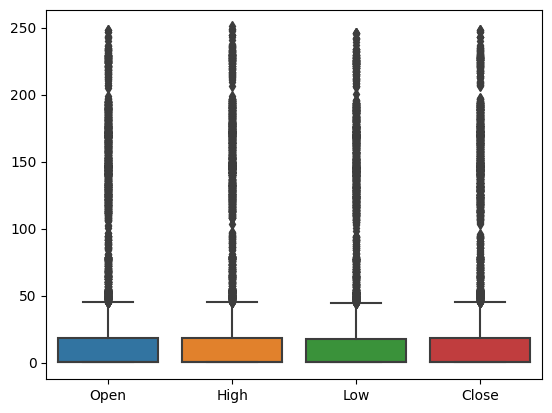

In [8]:
# Use boxplots for numerical columns:

sns.boxplot(data=data[['Open', 'High', 'Low', 'Close']])
plt.show()


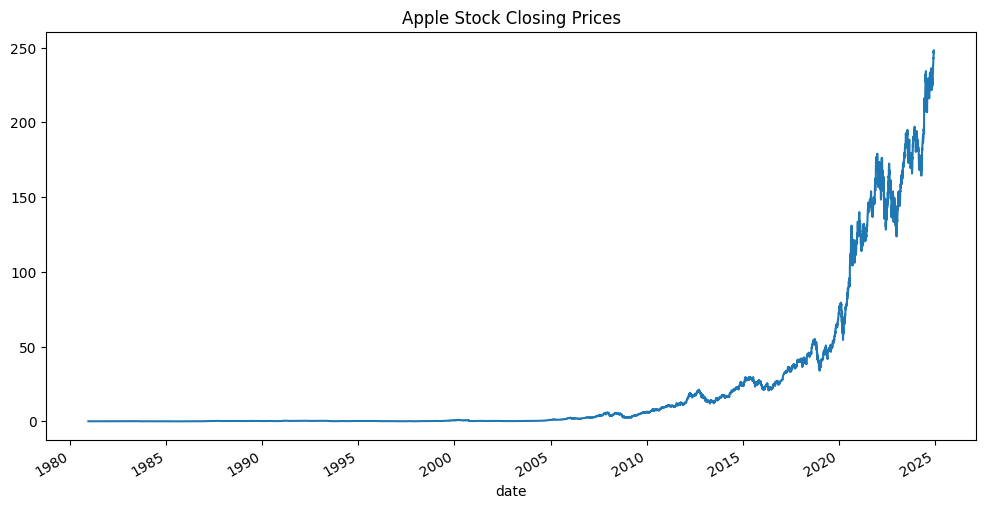

In [9]:
# Trends Over Time
data.set_index('date')['Close'].plot(figsize=(12, 6), title='Apple Stock Closing Prices')
plt.show()


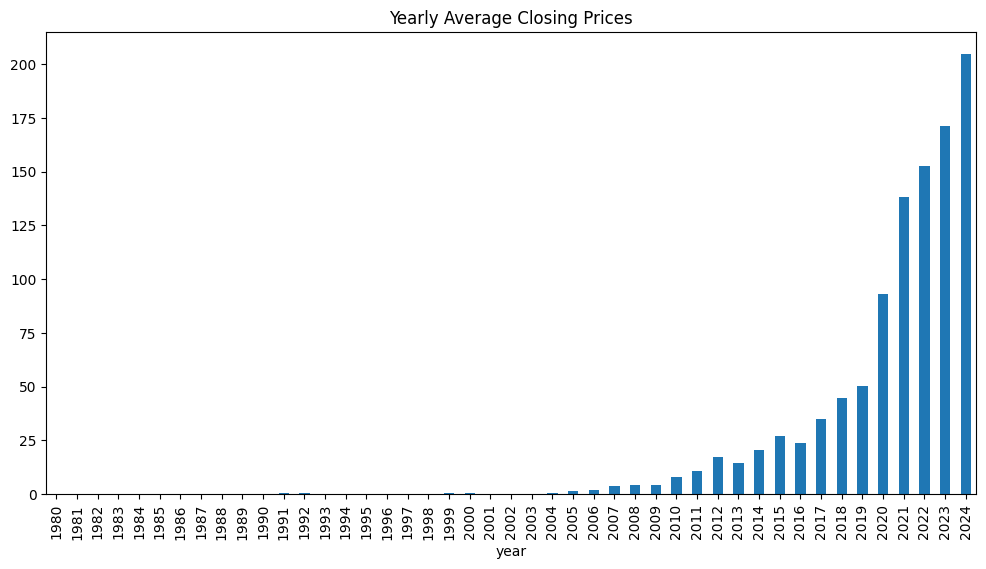

In [10]:
# Yearly Trends
yearly_trends = data.groupby('year')['Close'].mean()
yearly_trends.plot(kind='bar', figsize=(12, 6), title='Yearly Average Closing Prices')
plt.show()



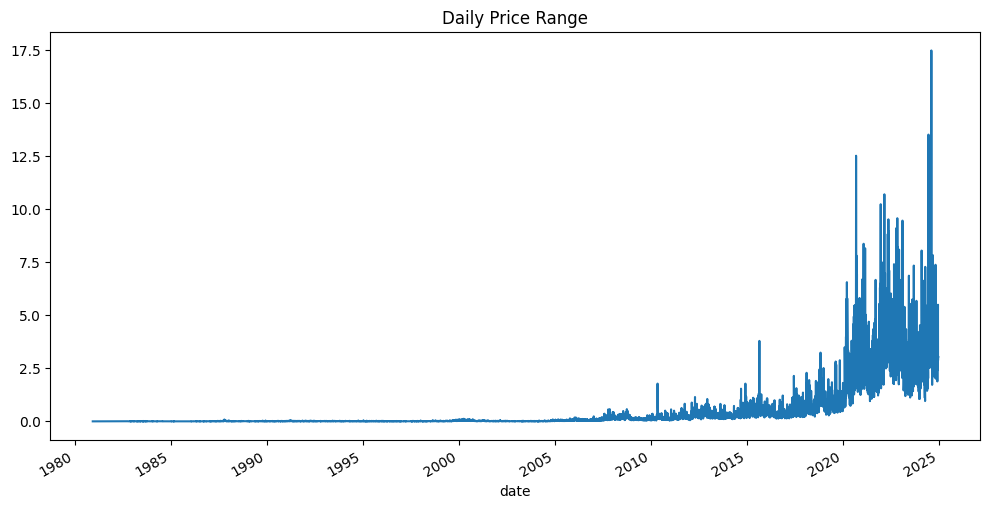

In [11]:
# Daily price range
data['Daily Range'] = data['High'] - data['Low']
data.set_index('date')['Daily Range'].plot(figsize=(12, 6), title='Daily Price Range')
plt.show()

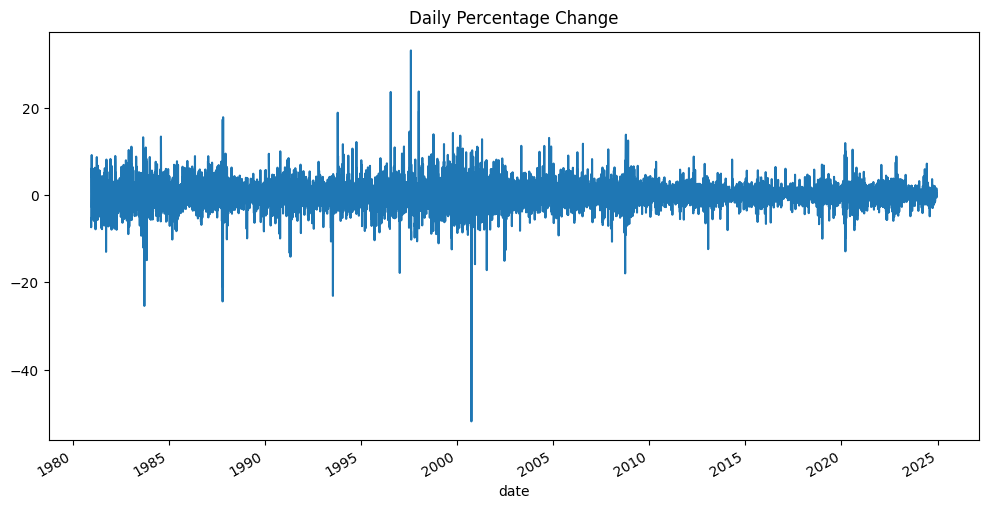

In [12]:
# Percentage change
data['Pct Change'] = data['Close'].pct_change() * 100
data.set_index('date')['Pct Change'].plot(figsize=(12, 6), title='Daily Percentage Change')
plt.show()


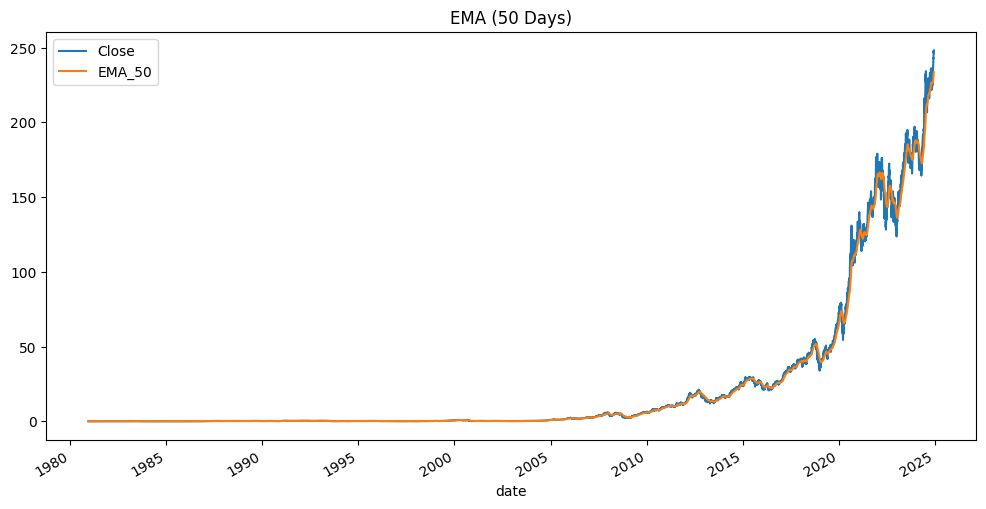

In [13]:

# Exponential Moving Average (EMA)
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data[['Close', 'EMA_50']].set_index(data['date']).plot(figsize=(12, 6), title='EMA (50 Days)')
plt.show()

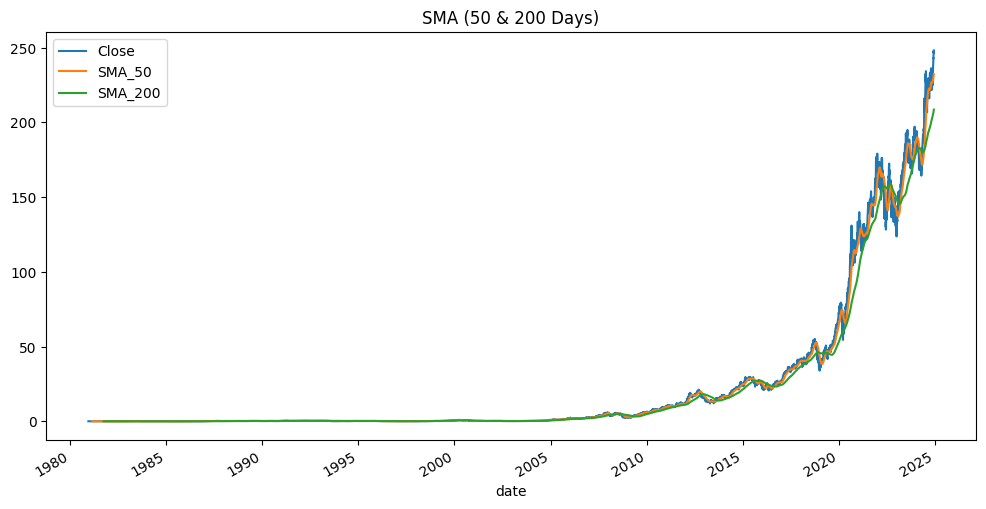

In [14]:

# Simple Moving Average (SMA)
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()
data[['Close', 'SMA_50', 'SMA_200']].set_index(data['date']).plot(figsize=(12, 6), title='SMA (50 & 200 Days)')
plt.show()

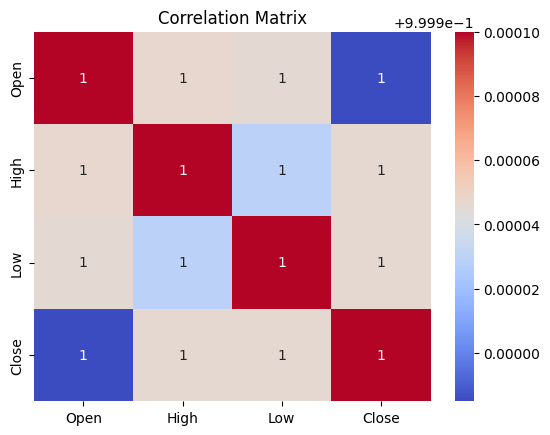

In [15]:

# Correlation matrix
correlation_matrix = data[['Open', 'High', 'Low', 'Close']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

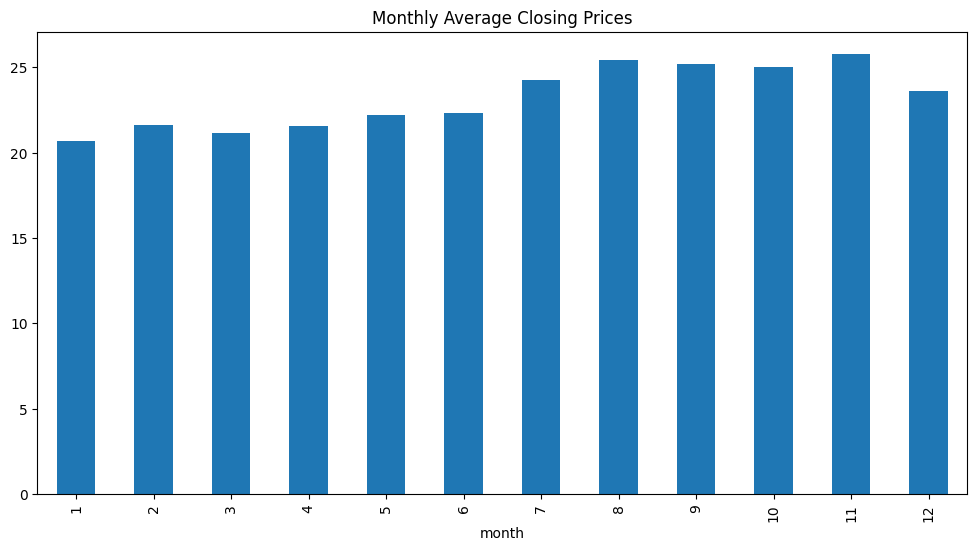

In [16]:

# Monthly trends
data['month'] = data['date'].dt.month
monthly_avg = data.groupby('month')['Close'].mean()
monthly_avg.plot(kind='bar', figsize=(12, 6), title='Monthly Average Closing Prices')
plt.show()

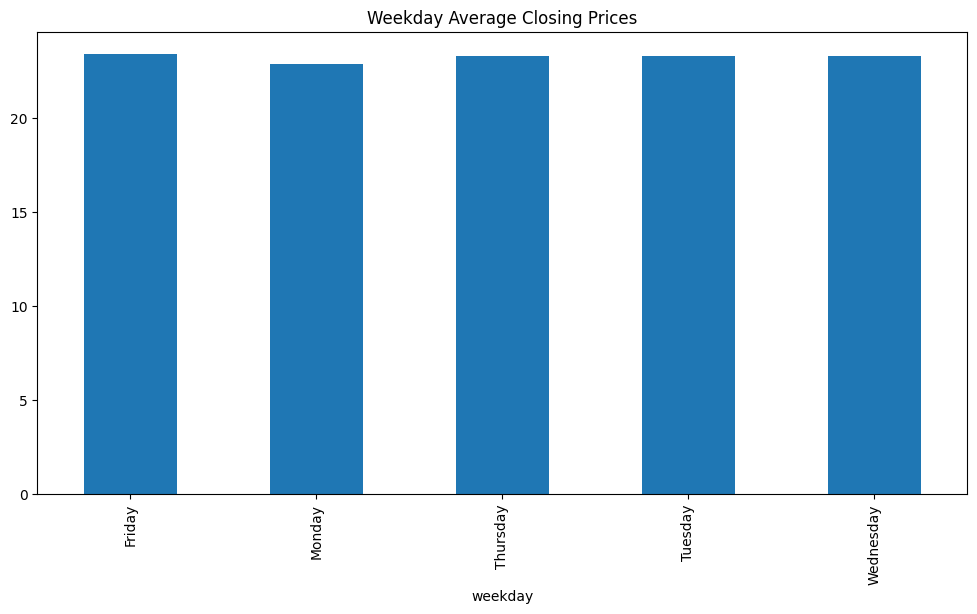

In [17]:
# Weekday trends:
data['weekday'] = data['date'].dt.day_name()
weekday_avg = data.groupby('weekday')['Close'].mean()
weekday_avg.plot(kind='bar', figsize=(12, 6), title='Weekday Average Closing Prices')
plt.show()

In [18]:
# Large price changes
significant_changes = data[abs(data['Pct Change']) > 5]
print(significant_changes[['date', 'Close', 'Pct Change']])

            date  Close  Pct Change
1     1980-12-15   0.09       -5.22
2     1980-12-16   0.09       -7.34
5     1980-12-19   0.10        6.10
8     1980-12-24   0.11        5.26
9     1980-12-26   0.12        9.23
...          ...    ...         ...
10526 2022-09-13 151.99       -5.87
10559 2022-10-28 153.86        7.56
10568 2022-11-10 145.34        8.90
10938 2024-05-03 182.72        5.98
10964 2024-06-11 206.68        7.26

[751 rows x 3 columns]


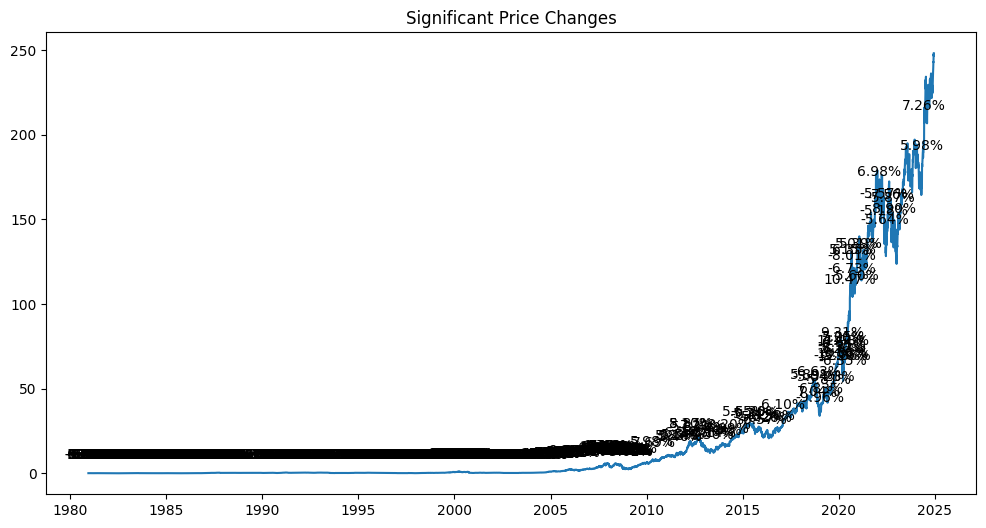

In [19]:
# Annotate significant events
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data['date'], data['Close'], label='Close Price')
for idx, row in significant_changes.iterrows():
    ax.annotate(f"{row['Pct Change']:.2f}%", (row['date'], row['Close']), textcoords="offset points", xytext=(0,10), ha='center')
plt.title('Significant Price Changes')
plt.show()

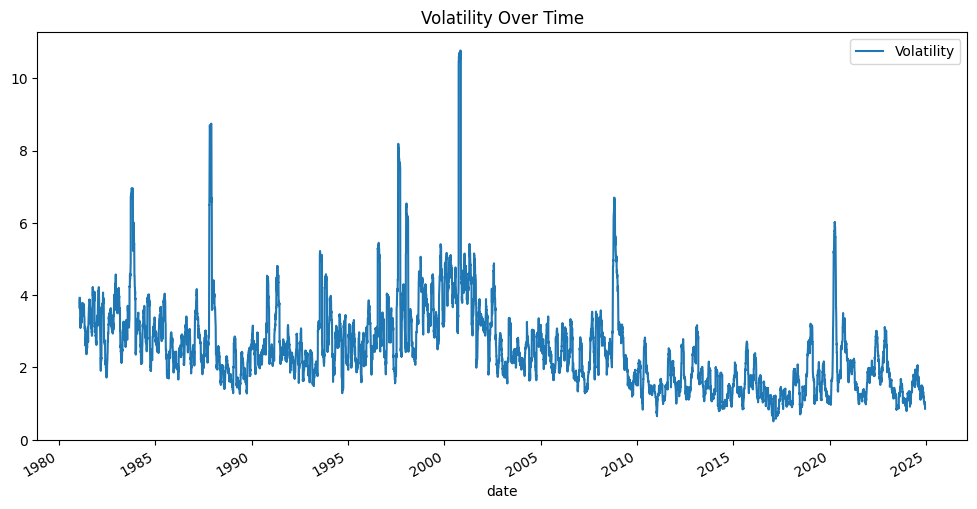

In [20]:
# Volatility clustering:
data['Volatility'] = data['Pct Change'].rolling(window=30).std()
data[['Volatility']].set_index(data['date']).plot(figsize=(12, 6), title='Volatility Over Time')
plt.show()

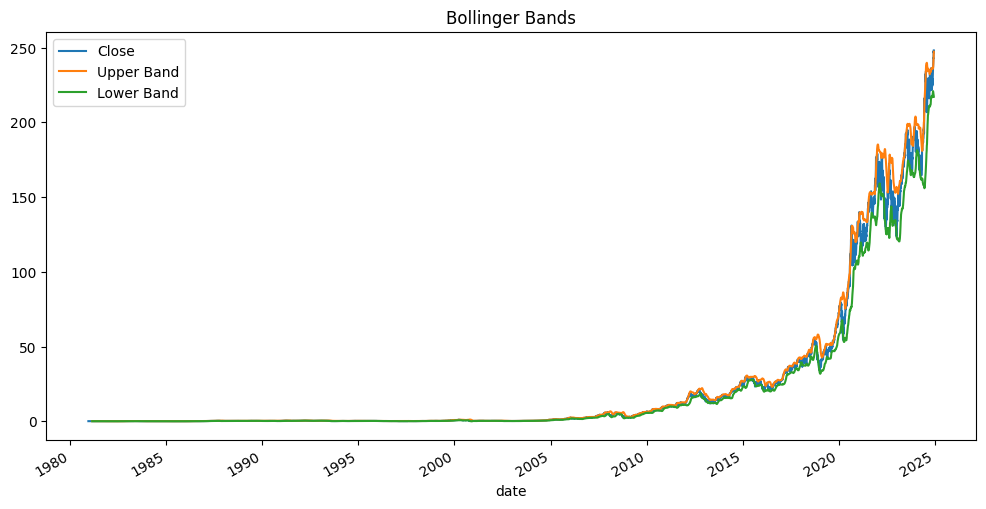

In [21]:
# Bollinger Bands:
data['Upper Band'] = data['SMA_50'] + 2 * data['Close'].rolling(window=50).std()
data['Lower Band'] = data['SMA_50'] - 2 * data['Close'].rolling(window=50).std()
data[['Close', 'Upper Band', 'Lower Band']].set_index(data['date']).plot(figsize=(12, 6), title='Bollinger Bands')
plt.show()


In [22]:
 # Prepare the Data for Forecasting

In [23]:
df1 = data.copy(deep = True)
df1['date'] = df1['Date'].apply(func=lambda x: str(x).split(sep=' ')[0])
df1['date'] = pd.to_datetime(df1['date'])
df1.set_index('date',inplace = True)
df1 = df1.resample('W').sum()
df1.head()


,Date,Open,High,Low,Close,year,Daily Range,Pct Change,EMA_50,SMA_50,SMA_200,month,weekday,Volatility,Upper Band,Lower Band
date,,,,,,,,,,,,,,,,
1980-12-14,1980-12-12 00:00:00-05:00,0.10,0.10,0.10,0.10,1980,0.00,0.00,0.10,0.00,0.00,12,Friday,0.00,0.00,0.00
1980-12-21,1980-12-15 00:00:00-05:001980-12-16 00:00:00-0...,0.46,0.46,0.46,0.46,9900,0.00,-1.08,0.49,0.00,0.00,60,MondayTuesdayWednesdayThursdayFriday,0.00,0.00,0.00
1980-12-28,1980-12-22 00:00:00-05:001980-12-23 00:00:00-0...,0.44,0.44,0.44,0.44,7920,0.00,23.58,0.39,0.00,0.00,48,MondayTuesdayWednesdayFriday,0.00,0.00,0.00
1981-01-04,1980-12-29 00:00:00-05:001980-12-30 00:00:00-0...,0.48,0.48,0.48,0.48,7921,0.00,-2.77,0.41,0.00,0.00,37,MondayTuesdayWednesdayFriday,0.00,0.00,0.00
1981-01-11,1981-01-05 00:00:00-05:001981-01-06 00:00:00-0...,0.55,0.55,0.55,0.55,9905,0.00,-7.53,0.52,0.00,0.00,5,MondayTuesdayWednesdayThursdayFriday,0.00,0.00,0.00


In [24]:
l3 = list(df1.columns)
l3.remove('Close')

df1.drop(columns = l3,inplace =True)
df1.head()

,Close
date,
1980-12-14,0.10
1980-12-21,0.46
1980-12-28,0.44
1981-01-04,0.48
1981-01-11,0.55


In [25]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window = 30).mean()
    MSTD = timeseries.rolling(window = 30).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [26]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

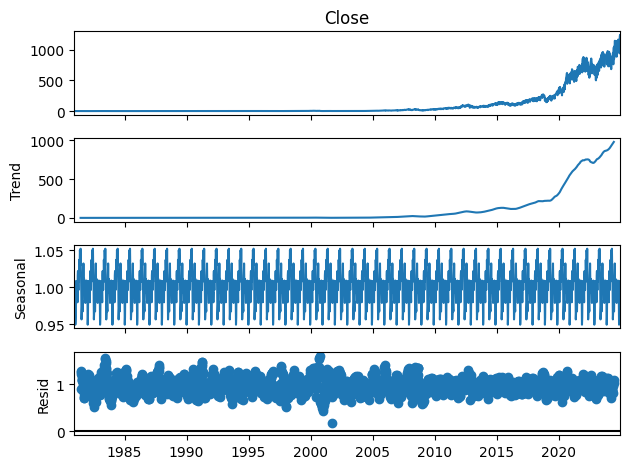

In [27]:
dec = sm.tsa.seasonal_decompose(df1['Close'], model = 'multiplicative').plot()
plt.show();

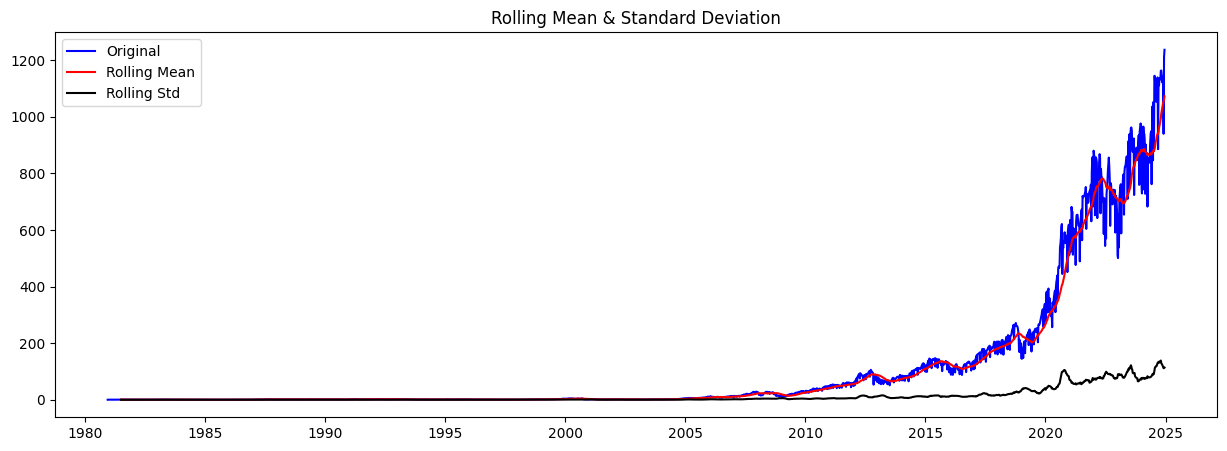

Results of Dickey-Fuller Test:
Test Statistic                   5.74
p-value                          1.00
#Lags Used                      26.00
Number of Observations Used   2270.00
Critical Value (1%)             -3.43
Critical Value (5%)             -2.86
Critical Value (10%)            -2.57
dtype: float64


In [28]:
test_stationarity(df1['Close'])

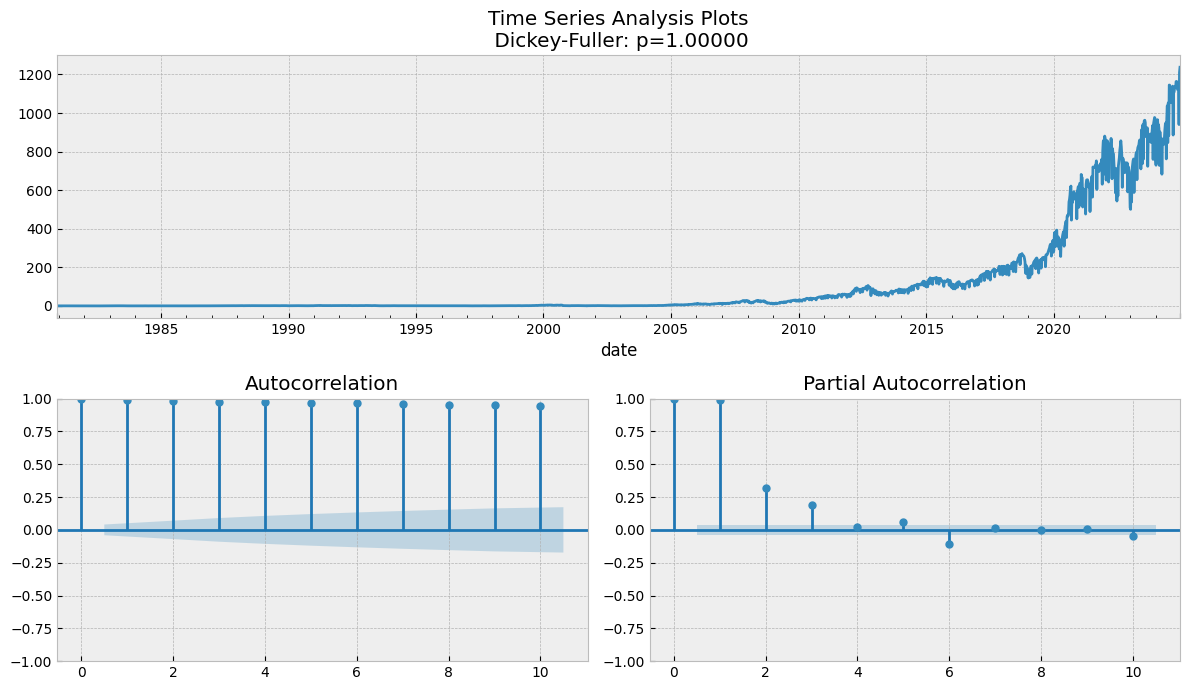

In [29]:
tsplot(df1['Close'],lags = 10)

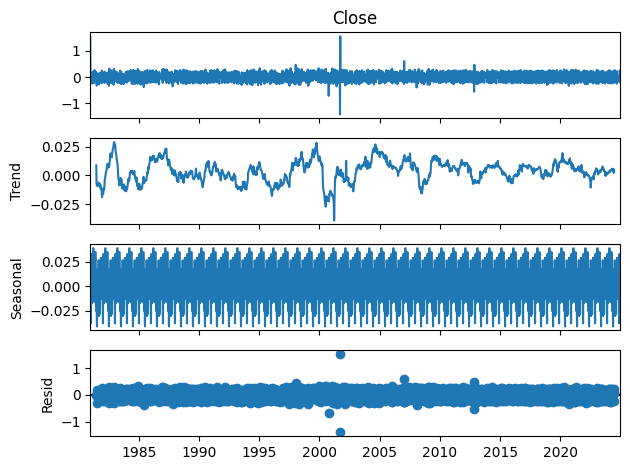

In [30]:
df1['Close'] = np.log(df1['Close'])
df1_log_diff = df1['Close'].diff()
df1_log_diff = df1_log_diff.dropna()

dec = sm.tsa.seasonal_decompose(df1_log_diff,period = 52).plot()
plt.show()

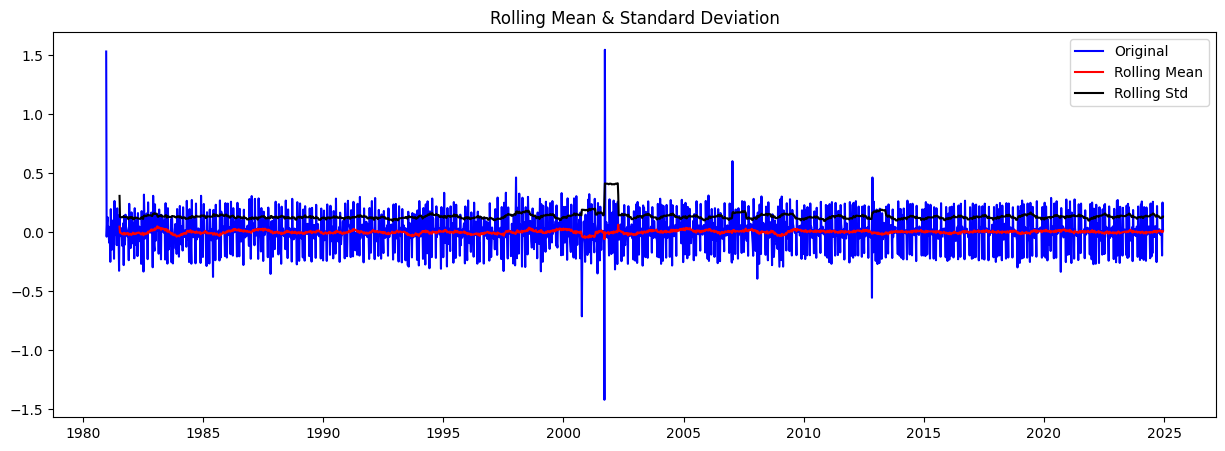

Results of Dickey-Fuller Test:
Test Statistic                 -11.85
p-value                          0.00
#Lags Used                      17.00
Number of Observations Used   2278.00
Critical Value (1%)             -3.43
Critical Value (5%)             -2.86
Critical Value (10%)            -2.57
dtype: float64


In [31]:
test_stationarity(df1_log_diff)

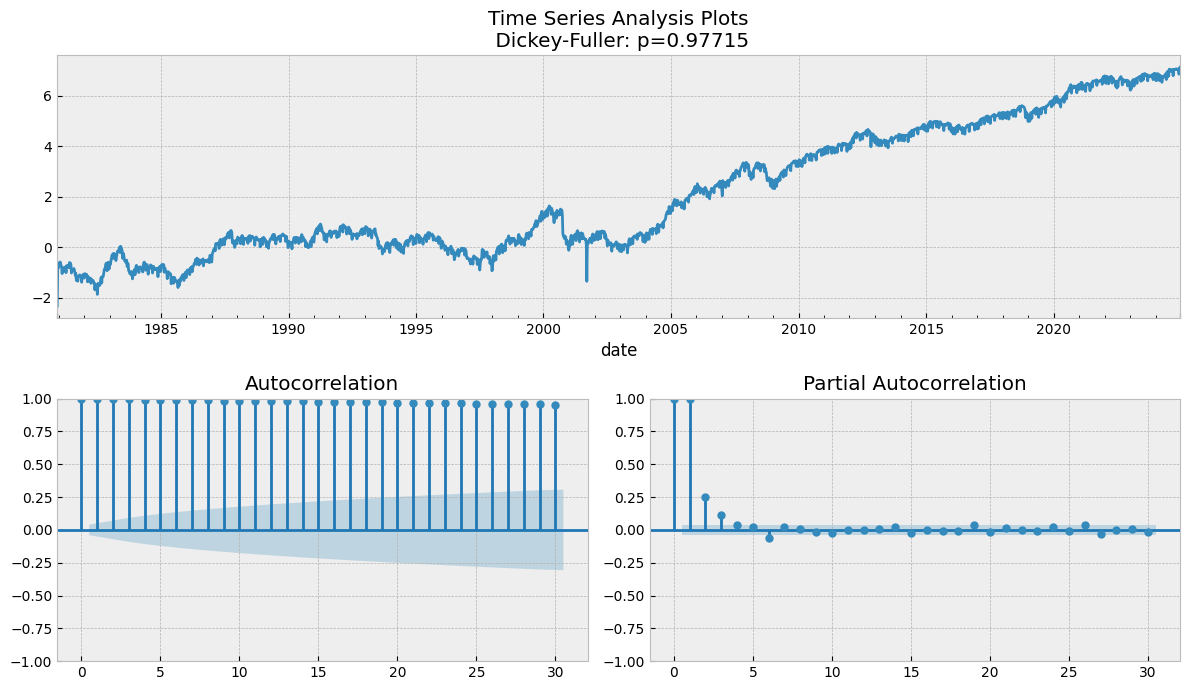

In [32]:
tsplot(df1['Close'],lags = 30)

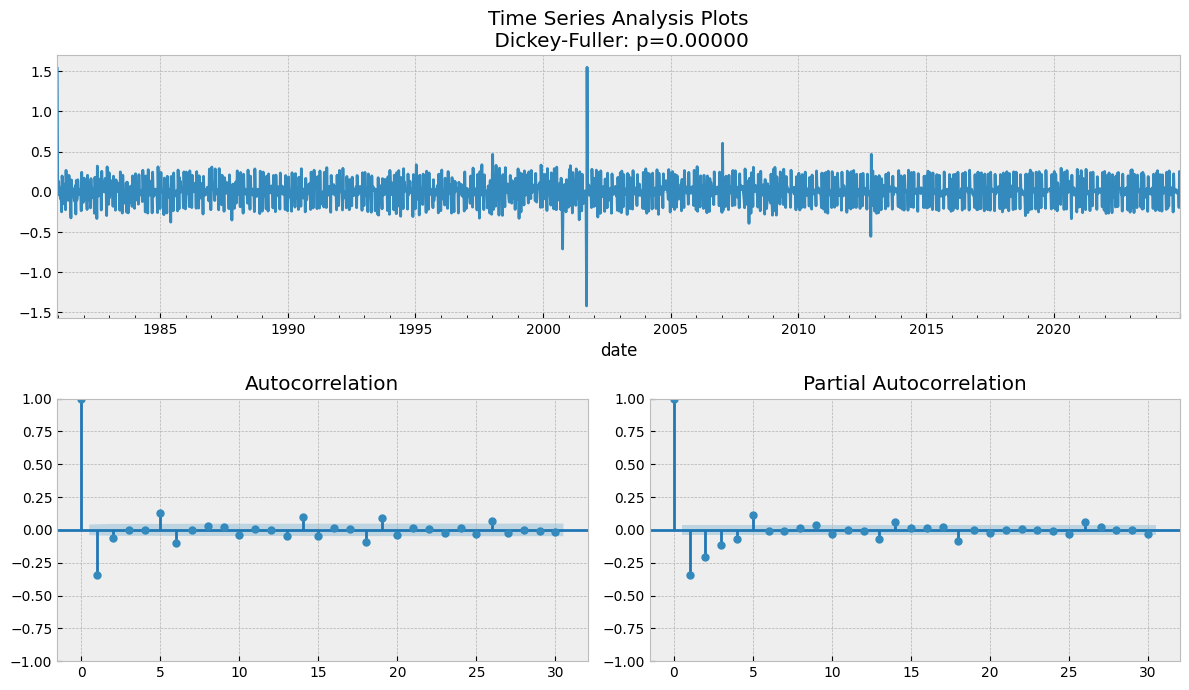

In [33]:
tsplot(df1_log_diff,lags = 30)

In [34]:
model = ARIMA(df1['Close'],order = (1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2297
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1424.252
Date:                Sat, 28 Dec 2024   AIC                          -2842.504
Time:                        14:01:24   BIC                          -2825.287
Sample:                    12-14-1980   HQIC                         -2836.226
                         - 12-15-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0556      0.032      1.735      0.083      -0.007       0.118
ma.L1         -0.5348      0.030    -18.072      0.000      -0.593      -0.477
sigma2         0.0169      0.000     97.599      0.0

In [35]:
# Fitted values of the model
predictions_ARIMA = pd.Series(model_fit.fittedvalues, copy=True)

# Reversing the 1st order Differencing by taking cumulative sum 
predictions_ARIMA_cumsum = predictions_ARIMA.cumsum()

# Creating a series with the same length as the original 'Log_AveragePrice'
# All the elements of this new series are same as the 1st element of the original 'Log_AveragePrice'
expected_log_values = pd.Series(df1['Close'].iloc[0], index = df1['Close'].index)

# Adding the elements of this newly created series with the cumulative sum series
expected_log_values = expected_log_values.add(predictions_ARIMA_cumsum,fill_value = 0)

# Taking log of the above series for getting the original values 
predictions_ARIMA_final = np.exp(expected_log_values)

fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(df1['Close'],label = 'Close')
plt.plot(predictions_ARIMA_final,label = 'Fitted Close Stock');
plt.legend(loc="upper left")
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_final - df1['Close'])**2)/len(df1['Close'])));

Error in callback <function _draw_all_if_interactive at 0x7c5ba63295a0> (for post_execute):


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale
/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2127: RuntimeWarning: overflow encountered in multiply
  ticks = np.arange(low, high + 1) * step + best_vmin


OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

<Figure size 1500x500 with 1 Axes>

In [36]:
# The error message OverflowError: cannot convert float infinity to integer 
# in an ARIMA modeling workflow typically arises due to numerical instability 
# in the calculations. This instability can be triggered
# by several factors when applying ARIMA to stock price data.


# Common Causes of the Error:
# Data Scaling Issues
# Excessive Differencing
# Poor Model Parameters
# Choosing inappropriate values
# Exponential Transformations


In [37]:
# Why ARIMA Might Not Be Ideal for Stock Prices
# 1. Stock Prices Are Noisy:
#     Stock price data often contains a lot of noise, making ARIMA less effective.
# 2. Market Factors:
#     Stock prices are influenced by external factors (news, earnings, etc.) 
#     that ARIMA doesn’t consider.
# 3. Non-Stationary Returns:
#     Even returns might exhibit patterns that ARIMA cannot capture effectively.
#So I consider using more advanced models like Prophet for 
# time series or LSTM for capturing patterns in sequential data.

In [38]:
# Forecasting Using LSTM (Deep Learning)
# Prepare the Data
# Normalize and convert the data into sequences.

# Scale the data:

In [ ]:
closing_prices = data['Close']

In [50]:


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(closing_prices.values.reshape(-1, 1))


In [51]:
sequence_length = 50  # Use the last 50 days to predict the next day
X, y = [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM input


In [52]:
# Build and Train the Model
# Define the LSTM model:

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [53]:
model.fit(X, y, epochs=10, batch_size=32)


Epoch 1/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - loss: 0.0035
Epoch 2/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - loss: 5.3708e-04
Epoch 3/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - loss: 4.6058e-04
Epoch 4/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - loss: 4.7420e-04
Epoch 5/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - loss: 3.7935e-04
Epoch 6/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - loss: 3.8452e-04
Epoch 7/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - loss: 4.0321e-04
Epoch 8/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - loss: 3.8255e-04
Epoch 9/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - loss: 3.4901e-04
Epoch 10/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - loss: 3.5511e-04


In [54]:
# Make Predictions
# Predict future prices:


test_data = scaled_data[-sequence_length:]  # Use the last 50 days
test_data = np.reshape(test_data, (1, test_data.shape[0], 1))
prediction = model.predict(test_data)
prediction = scaler.inverse_transform(prediction)  # Scale back to original range
print("Predicted Price:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
Predicted Price: [[244.30327]]


In [45]:
# Forecasting Using Prophet
# Prepare the Data
# Convert the data into a format suitable for Prophet.

In [55]:

prophet_data = closing_prices.reset_index()
prophet_data.columns = ['ds', 'y']  # Rename columns for Prophet


In [47]:
model = Prophet()
model.fit(prophet_data)


NameError: name 'Prophet' is not defined

In [ ]:
future = model.make_future_dataframe(periods=30)  # Forecast 30 days into the future
forecast = model.predict(future)


In [ ]:
model.plot(forecast)
plt.title('Prophet Forecast')
plt.show()
